In [318]:
import os
import numpy as np
import numpy.random as npr
import tensorflow as tf
import matplotlib.pyplot as plt
#plt.switch_backend('agg')

from scipy.integrate import odeint

keras = tf.keras
tf.compat.v1.enable_eager_execution()

#from neural_ode import NeuralODE

%config InlineBackend.figure_format = 'retina' #set 'png' here when working on notebook
%matplotlib inline

In [319]:
def SIR(z, t, beta, gamma):

    S, I, R = z

    dS = - beta * I * S / N 
    dI = beta * I * S / N - gamma * I
    dR = gamma * I 

    dzdt = [dS, dI, dR]
    return dzdt

# adattare il modello tempo-variabile -> così da considerare lockdown ecc? -> o con alcuni threshold

def plot_traj(trajectories, width = 1.):
    x1 = trajectories[:,0]
    x2 = trajectories[:,1]
    x3 = trajectories[:,2]
    s = plt.plot(x1, linewidth = width, label = 'Susceptible')
    i = plt.plot(x2, linewidth = width, label = 'Infected')
    r = plt.plot(x3, linewidth = width, label = 'Removed')
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
    plt.title('Simulation with R0 = %f' %R0 )
    plt.show()

    

In [320]:
data_size = 100
batch_time = 20   # da vedere cosa fa davvero
niters = 1000
batch_size = 50  # da vedere cosa fa davvero

N = 60000
infected_0 = N/1000
beta = 0.3  # farli time evolving?
gamma = 0.1

R0 = beta/gamma

In [321]:
t_grid = np.linspace(0, data_size, data_size)  # uniformly spaced data? -> even though advantage is learning with not uniformly spaced data
z0 = [N - infected_0, infected_0, 0] # initial conditions
true_yy = odeint(SIR, z0, t_grid, args=(beta, gamma))  # potrebbe aver senso tenerli in memoria se è lento

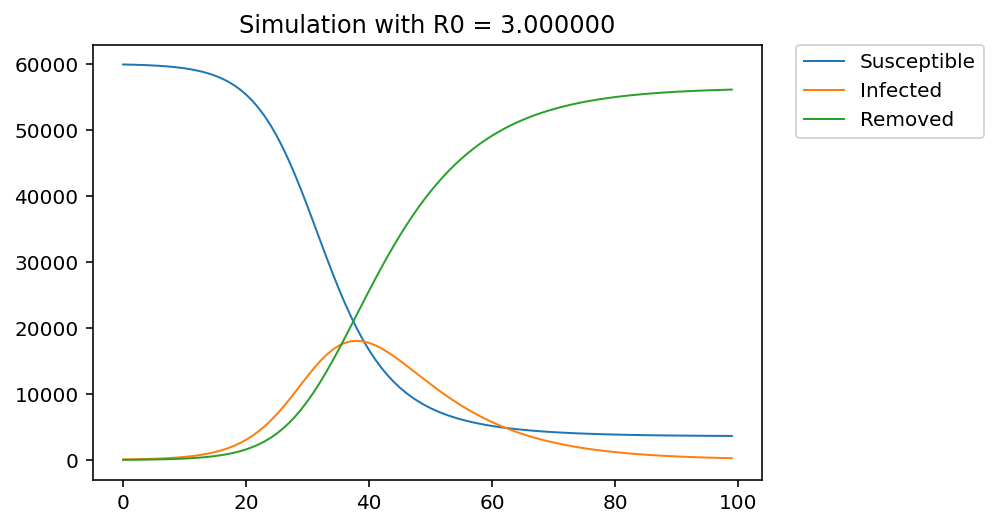

In [322]:
plot_traj(true_yy)

In [323]:
sigma_s = np.std(true_yy[:,0:1])  
sigma_i = np.std(true_yy[:,1:2]) 
sigma_r = np.std(true_yy[:,2:3]) 

In [356]:
true_y = true_yy.copy()

noise_level = 0.03  
sigma_normal = max(sigma_s, sigma_i, sigma_r)  

from stochastic.processes.continuous import FractionalBrownianMotion

fbm = FractionalBrownianMotion(hurst=0.2, t= data_size)
# in questo modo è autocorrelato negativamente -> giorno da tanti tamponi seguito da giorno da pochi tamponi

noise = abs(N/100 * fbm.sample(data_size-1))
noise_2 = abs(N/100 * fbm.sample(data_size-1))


true_y[:,0] = abs(true_y[:,0] - noise)        
true_y[:,1] = abs(true_y[:,1] + noise - noise_2)
true_y[:,2] = N - true_y[:,0] - true_y[:,1]

# problema in realtà è che i suscettibili e i rimossi possono crescere/decrescere

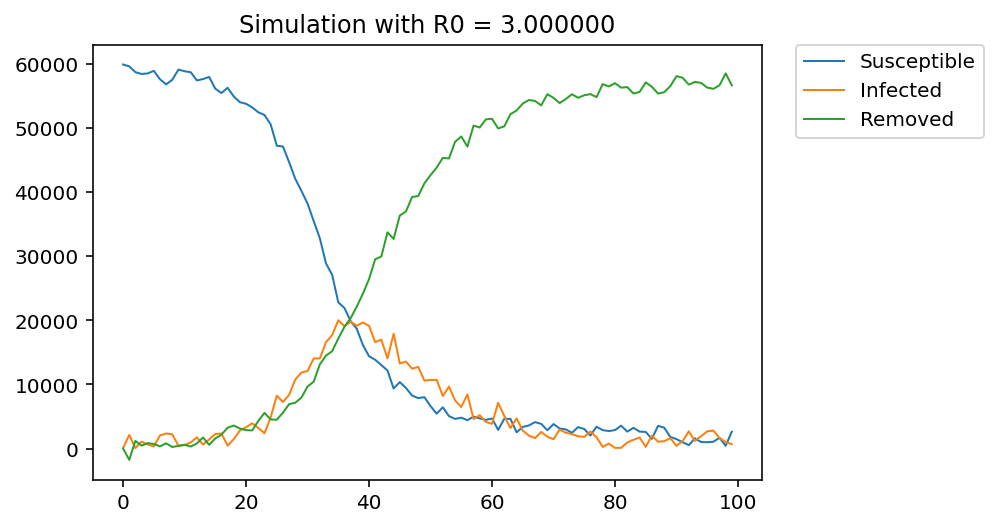

In [342]:
plot_traj(true_y)

In [343]:
sigma_s = np.std(true_yy[:,0:1])  
sigma_i = np.std(true_yy[:,1:2]) 
sigma_r = np.std(true_yy[:,2:3]) 

true_y[:, 0:1] = true_y[:, 0:1]/sigma_s
true_y[:, 1:2] = true_y[:, 1:2]/sigma_i
true_y[:, 2:3] = true_y[:, 2:3]/sigma_r

In [327]:
def get_batch():
    """Returns initial point and last point over sampled frament of trajectory"""
    starts = np.random.choice(np.arange(data_size - batch_time - 1, dtype=np.int64), batch_size, replace=False)
    # This randomly chooses from {0, 1, ... , data_size - batch_time - 1}, batch_size different elements
    batch_y0 = true_y[starts] 
    batch_yN = true_y[starts + batch_time]
    # The function returns a tensor composed by some y0 and the respective yN,
    # being y0 + DeltaT.
    return tf.cast(batch_y0, dtype=tf.float32), tf.cast(batch_yN, dtype=tf.float32)

In [344]:
num_param = 5 # Number of parameters
para_num = num_param

t0 = t_grid[:batch_time][0]  # t0 = first element of t_grid
t1 = t_grid[:batch_time][-1]  # t1 = the element of t_grid at batch_time
t_in = np.linspace(t0, t1, 20)  # The time grid between t0 and t1

batch_y0, batch_yN = get_batch()  # Returns the first and the last y observed for each batch

In [334]:
from neural_ode import NeuralODE

In [347]:
niters_pre = 200  # Number of iterations of the preconditioner

class ODEModel_pre(tf.keras.Model):
    def __init__(self):
        super(ODEModel_pre, self).__init__()
        self.Weights = tf.Variable(tf.random.normal([num_param, 1], dtype=tf.float32)*0.01, dtype=tf.float32)
    # Initializer: assign normally distributed random weights which are very close to zero

    def call(self, inputs, **kwargs):
        t, y = inputs
        h = y
        S = h[:, 0:1] * sigma_s
        I = h[:, 1:2] * sigma_i
        R = h[:, 2:3] * sigma_r

        # ma che sintassi di merda -> facciamolo adattativo

        p1 = self.Weights[0]
        p2 = self.Weights[1]
        p3 = self.Weights[2]
        p4 = self.Weights[3]
        p5 = self.Weights[4]

        dS = - p1 * I * S / N + p3 * S
        dI = p1 * I * S / N - p2 * I + p4 * I
        dR = p2 * I + p5 * R
        
        h_out = tf.concat([dS/sigma_s, dI/sigma_i, dR/sigma_r], 1)
        return h_out


model_pre = ODEModel_pre()  
neural_ode_pre = NeuralODE(model_pre, t_in) 
optimizer = tf.compat.v1.train.AdamOptimizer(3e-2)  

In [349]:
@tf.function
def compute_gradients_and_update_pre(batch_y0, batch_yN):
    """Takes start positions (x0, y0) and final positions (xN, yN)"""
    pred_y = neural_ode_pre.forward(batch_y0)  # Predict y using Runge-Kutta 4 for each y0 in batch_y0
    with tf.GradientTape() as g_pre:
        g_pre.watch(pred_y)
        loss = tf.reduce_mean(input_tensor=(pred_y - batch_yN)**2) + tf.reduce_sum(input_tensor=tf.abs(model_pre.trainable_weights[0]))
        # This step is computing the loss function
    dLoss = g_pre.gradient(loss, pred_y)  # Here we compute the gradient of the loss function
    h_start, dfdh0, dWeights = neural_ode_pre.backward(pred_y, dLoss)  # Here we compute the dWeights
    optimizer.apply_gradients(zip(dWeights, model_pre.weights))  # Here we update the weights
    return loss, dWeights

# Compile EAGER graph to static (this will be much faster)
# compute_gradients_and_update_pre = tfe.defun(compute_gradients_and_update_pre)

parameters_pre = np.zeros((para_num, 1))

for step in range(niters_pre):
    loss, dWeights = compute_gradients_and_update_pre(batch_y0, batch_yN)
    parameters_pre = model_pre.trainable_weights[0].numpy()
print(parameters_pre)

[[ 0.3292893 ]
 [ 0.10463119]
 [ 0.00042905]
 [-0.00633255]
 [ 0.0007472 ]]


In [354]:
niters_pre = 50  # Number of iterations of the preconditioner

class ODEModel_pre(tf.keras.Model):
    def __init__(self):
        super(ODEModel_pre, self).__init__()
        self.Weights = tf.Variable(tf.random.normal([num_param, 1], dtype=tf.float32)*0.01, dtype=tf.float32)
    # Initializer: assign normally distributed random weights which are very close to zero

    def call(self, inputs, **kwargs):
        t, y = inputs
        h = y
        #S = h[:, 0:1] * sigma_s
        I = h[:, 1:2] * sigma_i
        R = h[:, 2:3] * sigma_r
        
        S = N - h[:, 1:2] * sigma_i - h[:, 2:3] * sigma_r

        # ma che sintassi di merda -> facciamolo adattativo

        p1 = self.Weights[0]
        p2 = self.Weights[1]
        p3 = self.Weights[2]
        p4 = self.Weights[3]
        p5 = self.Weights[4]

        dS = - p1 * I * S / N + p3 * S
        dI = p1 * I * S / N - p2 * I + p4 * I
        dR = p2 * I + p5 * R
        
        h_out = tf.concat([dS/sigma_s, dI/sigma_i, dR/sigma_r], 1)
        return h_out


model_pre = ODEModel_pre()  
neural_ode_pre = NeuralODE(model_pre, t_in) 
optimizer = tf.compat.v1.train.AdamOptimizer(3e-2)  

In [355]:
@tf.function
def compute_gradients_and_update_pre(batch_y0, batch_yN):
    """Takes start positions (x0, y0) and final positions (xN, yN)"""
    pred_y = neural_ode_pre.forward(batch_y0)  # Predict y using Runge-Kutta 4 for each y0 in batch_y0
    with tf.GradientTape() as g_pre:
        g_pre.watch(pred_y)
        loss = tf.reduce_mean(input_tensor=(pred_y - batch_yN)**2) + tf.reduce_sum(input_tensor=tf.abs(model_pre.trainable_weights[0]))
        # This step is computing the loss function
    dLoss = g_pre.gradient(loss, pred_y)  # Here we compute the gradient of the loss function
    h_start, dfdh0, dWeights = neural_ode_pre.backward(pred_y, dLoss)  # Here we compute the dWeights
    optimizer.apply_gradients(zip(dWeights, model_pre.weights))  # Here we update the weights
    return loss, dWeights

# Compile EAGER graph to static (this will be much faster)
# compute_gradients_and_update_pre = tfe.defun(compute_gradients_and_update_pre)

parameters_pre = np.zeros((para_num, 1))

for step in range(niters_pre):
    loss, dWeights = compute_gradients_and_update_pre(batch_y0, batch_yN)
    parameters_pre = model_pre.trainable_weights[0].numpy()
    print(parameters_pre)

[[-0.02502979]
 [ 0.02339484]
 [-0.03103986]
 [-0.03783064]
 [ 0.02865508]]
[[-0.0293327 ]
 [ 0.0415648 ]
 [-0.04882446]
 [-0.05652229]
 [ 0.01137462]]
[[-0.02657422]
 [ 0.05507014]
 [-0.04883622]
 [-0.06914932]
 [-0.00378406]]
[[-0.02047985]
 [ 0.06606188]
 [-0.039195  ]
 [-0.07796418]
 [-0.01128557]]
[[-0.01216772]
 [ 0.07535312]
 [-0.02629291]
 [-0.08428562]
 [-0.01249789]]
[[-0.00178116]
 [ 0.08335847]
 [-0.01553871]
 [-0.0888763 ]
 [-0.00936721]]
[[ 0.01072378]
 [ 0.09032409]
 [-0.01109408]
 [-0.09214803]
 [-0.00330909]]
[[ 0.02511524]
 [ 0.09638974]
 [-0.01302507]
 [-0.09434864]
 [ 0.00434688]]
[[ 0.04092209]
 [ 0.101615  ]
 [-0.01916842]
 [-0.09568021]
 [ 0.01176095]]
[[ 0.057643  ]
 [ 0.10600854]
 [-0.02708873]
 [-0.09632467]
 [ 0.01633235]]
[[ 0.07491647]
 [ 0.10958213]
 [-0.03438506]
 [-0.09639908]
 [ 0.01617917]]
[[ 0.09262791]
 [ 0.11240366]
 [-0.03903342]
 [-0.09588797]
 [ 0.01212116]]
[[ 0.1109128 ]
 [ 0.11456065]
 [-0.03997925]
 [-0.09465911]
 [ 0.00647576]]
[[ 0.1301045